This Jupyter Notebook is used for extracting data from multiple sources. The sources include trip data, occupancy data, and parking lot data. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import os
import folium
from pathlib import Path
import boto3

# import from src
os.chdir('../src')
from trips_data_retrieval import get_agg_trips_by_market, get_agg_trips
import inrix_data_science_utils.maps.quadkey as qkey

# set paths
data_path = Path('../data')

### Extract the 6 Flags Polygon Shapes

In [2]:
from polygon_retrieval import get_polygons

# Six Flags
brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
poly_file_name = data_path / 'six_flags_polygons.csv'

In [3]:

if not os.path.exists(poly_file_name):
    polygon_df = get_polygons(brand_id, format='df', echo_query=True)
    relevant_cols = ['location_name', 'top_category', 'sub_category', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours',
                 'category_tags', 'polygon_wkt', 'polygon_class', 'enclosed', 'is_synthetic', 'includes_parking_lot', 'wkt_area_sq_meters', 'tz', 'year',
                 'month', 'pg_id', 'parking_wkt']
    polygon_df = polygon_df[relevant_cols]
    polygon_df.to_csv(poly_file_name, index=False)
else:
    polygon_df = pd.read_csv(poly_file_name)

In [4]:
# make a new df with just the unique latitude and longitude columns
store_locations_df = polygon_df[['latitude', 'longitude', 'street_address', 'city', 'region']].drop_duplicates()
display(store_locations_df)

six_flag_stores = folium.Map(zoom_start=15)
for i, row in store_locations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='blue',
        radius=4
    ).add_to(six_flag_stores)
six_flag_stores.fit_bounds(six_flag_stores.get_bounds())
six_flag_stores

,latitude,longitude,street_address,city,region
0,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY
53,42.369309,-87.935103,542 N State Route 21,Gurnee,IL
76,38.906271,-76.776467,13710 Central Ave,Bowie,MD
148,40.141007,-74.438164,1 Six Flags Blvd,Jackson,NJ
334,32.761690,-97.081166,1800 E Lamar Blvd,Arlington,TX
355,35.463453,-97.589371,3908 W Reno Ave,Oklahoma City,OK
359,42.927651,-78.385383,9993 Alleghany Rd,Corfu,NY
403,42.245289,-88.964116,7820 Cherryvale N Blvd,Cherry Valley,IL


In [5]:
city = 'Arlington'
test_site = store_locations_df[store_locations_df['city'] == city].iloc[0]
test_point = test_site['latitude'], test_site['longitude']

# get the quadkey for a specific location
qk = qkey.QuadKey('0')
qk = qk.from_geo(test_point, level=13)
print(qk)
qk.show()

0231123213130


#### Map the parking lots at each store

epsg:4326


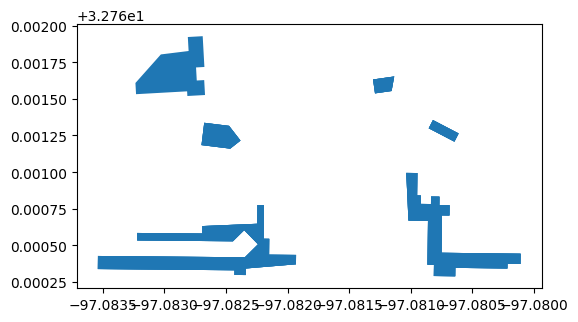

In [6]:
lot_gpd = polygon_df.copy()
geometry = lot_gpd['parking_wkt'].apply(wkt.loads)
lot_gpd = gpd.GeoDataFrame(lot_gpd, crs='epsg:4326', geometry=geometry)
print(lot_gpd.crs)
lot_gpd[lot_gpd['city'] == city].plot(figsize=(6, 6))
plt.show()

In [7]:
lot_map = folium.Map(zoom_start=10)
cities = lot_gpd['city'].unique()
# add pois to lot map
for city in cities:
    city_gpd = lot_gpd[lot_gpd['city'] == city].copy()
    geom = city_gpd['polygon_wkt'].values[0]
    # convert geom to a shapely geometry object
    geom = wkt.loads(geom)
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3})
    folium.Popup(city).add_to(geo_j)
    geo_j.add_to(lot_map)

# add parking lots to lot map
for _, r in lot_gpd.iterrows():
    geom = r['geometry']  # this needs to be a shapely geometry object
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8})
    geo_j.add_to(lot_map)
print('loop done')
lot_map

loop done


### Extracting Trips

In [8]:
# Change these as needed
# qk_list = ['02123003']  # seattle area
# qk_list = ['021230032110033003', '021230032110033012', '021230032110033021', '021230032110033030']  # QFC North Bend
qk_list = [str(qk)]  # Six Flags
start_date = pd.to_datetime('2023-01-01 00:00:00')
end_date = pd.to_datetime('2023-01-30 00:01:00')
trip_type = 'dest'
filename_description = 'Burien6Flags'

# don't change these
start_year = str(start_date.year)
start_month = str(start_date.month).zfill(2)
start_day = str(start_date.day).zfill(2)
end_year = str(end_date.year)
end_month = str(end_date.month).zfill(2)
end_day = str(end_date.day).zfill(2)
out_filename = f'''{trip_type}_trips_{filename_description}_{start_year}-{start_month}-{start_day}_to_{
                end_year}-{end_month}-{end_day}.csv'''
out_file_path = data_path / out_filename
print('Will save the csv to ', out_file_path)
origin_qk = (trip_type == 'orig')

table_name = 'tripdata_na_restricted'
s3_tapp_data_dir = 'data-restricted'
s3_tapp_region = 'NA'

Will save the csv to  ..\data\dest_trips_Burien6Flags_2023-01-01_to_2023-01-30.csv


In [9]:
# if out_file_path not in the data folder, save it there
if not os.path.exists(out_file_path):
    trips_df = get_agg_trips(
        agg_file_path = out_file_path,
        echo_query=True,
        table_name=table_name,
        start_date=start_date,
        end_date=end_date,
        qk_filter_list=qk_list,
        s3_tapp_data_dir=s3_tapp_data_dir,
        s3_tapp_region=s3_tapp_region,
        origin_qk=origin_qk,
    )
    print('Saved the csv to ', out_file_path)
else:
    trips_df = pd.read_csv(out_file_path)

trips_df['date'] = pd.to_datetime(trips_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
display(trips_df)


            WITH qk_counts AS(
            SELECT start_time, provider, start_lat, start_lon, end_lat, end_lon, 
                    BING_TILE_QUADKEY(BING_TILE_AT(end_lat, end_lon, 17)) AS dest_qk17,
                    BING_TILE_QUADKEY(BING_TILE_AT(start_lat, start_lon, 17)) AS orig_qk17,
                    year, month, day, SUBSTR(start_time,12, 2) AS hour, SUBSTR(start_time, 15, 2) AS minute,
                    SUBSTR(start_time, 18, 2) AS second, trip_id, is_moving

            FROM "inrixdatascience"."tripdata_na_restricted"
            WHERE
                qk = '02311'
                AND CAST(year as INT) BETWEEN 2023 AND 2023
                AND CAST(month as INT) BETWEEN 1 AND 1
                AND CAST(day AS INT) BETWEEN 1 AND 30
                AND provider IN ('475', '458', '470')
                AND REGEXP_LIKE(
                        BING_TILE_QUADKEY(BING_TILE_AT(end_lat, end_lon, 13)),
                        '(0231123213130)'
                    )
             

,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving,date
0,2023,01,03,18,56,55,02311232131302302,02311232131302321,32.738659,-97.106169,32.734972,-97.104395,1,59fb82fee54fb40e417d037354f47060,1,2023-01-03 18:56:55
1,2023,01,09,19,23,47,02311233001212110,02311232131302331,33.043586,-96.792914,32.734523,-97.098082,1,45e92a4aa4517f3899d7a5aec4b23599,1,2023-01-09 19:23:47
2,2023,01,03,17,50,02,02311232131121020,02311232131301022,32.799540,-97.094893,32.761066,-97.095551,1,acff1b1c43dcf75dd4a60d352210b94f,1,2023-01-03 17:50:02
3,2023,01,03,19,37,05,02311232131121123,02311232131301131,32.798658,-97.080861,32.763845,-97.077761,1,b95fa3e0a24da3e7f83c22e5f9febe53,1,2023-01-03 19:37:05
4,2023,01,20,13,42,40,02311232131201121,02311232131300223,32.763589,-97.169706,32.751271,-97.115696,1,f277d64f62168df0c6ac96dc5f43b18b,1,2023-01-20 13:42:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151310,2023,01,26,21,07,10,02311232133100203,02311232131303201,32.682983,-97.113688,32.739762,-97.093401,1,ccf556985161c8806116dc4a078b9abd,1,2023-01-26 21:07:10
151311,2023,01,22,08,34,40,02311232131320002,02311232131302321,32.728130,-97.118181,32.734745,-97.103928,1,f7d650636bbea5ee87f92e5d6c6f50da,1,2023-01-22 08:34:40
151312,2023,01,22,19,06,56,02311232131320023,02311232131300113,32.722901,-97.114453,32.765435,-97.098911,1,ef7caa11c1b8f33121c64a3063a0572f,1,2023-01-22 19:06:56
151313,2023,01,22,17,53,20,02311232131320023,02311232131301223,32.722624,-97.114213,32.750848,-97.093736,1,fe08e0adee0165eaf7e3aeb9e4a53cf0,1,2023-01-22 17:53:20


In [10]:
m = lot_map
# m = folium.Map(zoom_start=10)

N = 100
for i in range(0, trips_df.shape[0], N):
    folium.CircleMarker(
        location=[
            trips_df['end_lat'].values[i],
            trips_df['end_lon'].values[i]
        ],
        color='red',
        radius=1
    ).add_to(m)
# m.fit_bounds(m.get_bounds())

# for i in range(0, trips_df.shape[0], N):
#     folium.CircleMarker(
#         location=[
#             trips_df['start_lat'].values[i],
#             trips_df['start_lon'].values[i]
#         ],
#         color='blue',
#         radius=1
#     ).add_to(m)
# m.fit_bounds(m.get_bounds())

m

### Get the Parking Occupancy Ground Truth Data

In [11]:
from parking_data_retrieval import get_parking_data

In [12]:
destination_name = 'Ann Arbor'
datetime_start = '2023-01-01'
datetime_end = '2023-01-31'

parking_filename = f'parking_{destination_name}_{datetime_start}_{datetime_end}.csv'

In [13]:
if not os.path.exists(data_path / parking_filename):
    parking_df = get_parking_data(pk_lot=None,
                                  destination_name=destination_name,
                                  datetime_start=datetime_start,
                                  datetime_end=datetime_end,
                                  echo_query=True)
    relevant_cols = ['dt_start_date', 'dt_end_date', 'i_avail', 'i_occ', 'f_pct_occ', 'pk_lot_alias',
                     'f_occupancy_rank', 'pk_lot']
    parking_df = parking_df[relevant_cols]
    parking_df.to_csv(data_path / parking_filename, index=False)
else:
    parking_df = pd.read_csv(data_path / parking_filename)
print(parking_df.shape)
parking_df.head()

(11527, 8)


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot
0,2023-01-31 01:46:32.261606+00:00,2023-01-31 05:46:32.261606+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065
1,2023-01-31 01:18:38.803630+00:00,2023-01-31 05:18:38.803630+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065
2,2023-01-31 00:40:47.227499+00:00,2023-01-31 04:40:47.227499+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065
3,2023-01-30 21:14:13.444933+00:00,2023-01-31 01:14:13.444933+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065
4,2023-01-30 21:09:49.512968+00:00,2023-01-31 01:09:49.512968+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065


#### Parking Occupancy Initial Plots

In [14]:
print(parking_df['pk_lot'].unique())

[ 93065  93071  93121  93318  93240  93313  93059  93224 118208]


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot
8854,2023-01-01 06:12:40+00:00,2023-01-01 10:12:40+00:00,849,NaN,14.0,63d906e6-ee09-43dd-883a-eeb41a5056b7,3.0,93059
10121,2023-01-01 06:12:40+00:00,2023-01-01 10:12:40+00:00,662,NaN,20.0,50a13dbb-39f4-48ac-8839-a148bb2c1740,3.0,93224
11502,2023-01-01 06:12:40+00:00,2023-01-01 10:12:40+00:00,701,NaN,6.0,a9605935-8157-482b-80a4-404717478495,3.0,118208
8853,2023-01-01 06:12:40+00:00,2023-01-01 10:12:40+00:00,849,NaN,14.0,63d906e6-ee09-43dd-883a-eeb41a5056b7,3.0,93059
11501,2023-01-01 06:12:40+00:00,2023-01-01 10:12:40+00:00,701,NaN,6.0,a9605935-8157-482b-80a4-404717478495,3.0,118208
...,...,...,...,...,...,...,...,...
3846,2023-01-30 21:13:31+00:00,2023-01-31 01:13:31+00:00,467,NaN,42.0,fcc952a7-c7ba-4822-8987-888c98b5ce6d,3.0,93318
10249,2023-01-30 21:13:31+00:00,2023-01-31 01:13:31+00:00,563,NaN,25.0,a9605935-8157-482b-80a4-404717478495,3.0,118208
5477,2023-01-30 21:13:31+00:00,2023-01-31 01:13:31+00:00,278,NaN,52.0,afc9d175-efa7-4091-bb2e-669f0aaea96f,3.0,93240
3,2023-01-30 21:14:13.444933+00:00,2023-01-31 01:14:13.444933+00:00,0,NaN,100.0,10906160-0df3-4584-ac7d-16f12f15808c,3.0,93065


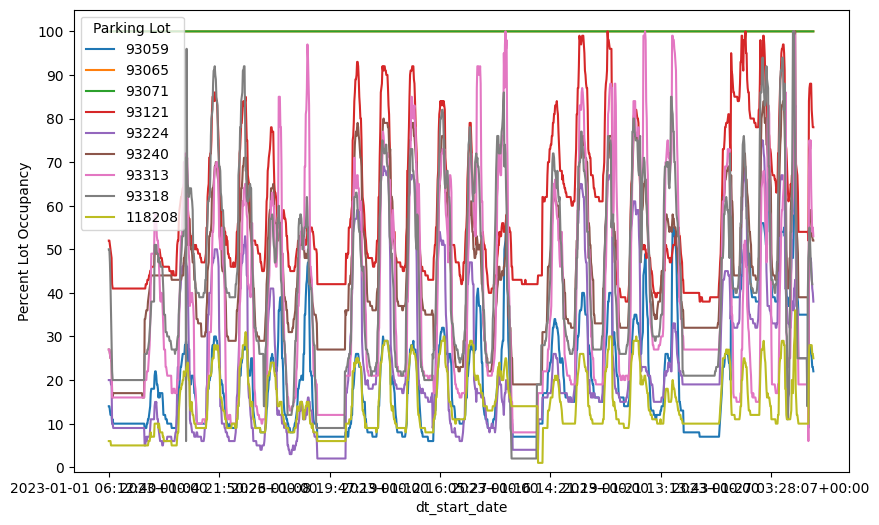

In [15]:
# line graph of f_pct_occ vs. dt_start_date grouped by pk_lot
day_df = parking_df[(parking_df['dt_start_date'] >= '2023-01-01') & (parking_df['dt_start_date'] <= '2023-01-31')]
# order day_df by dt_start_date
day_df = day_df.sort_values('dt_start_date')
display(day_df)

plt.figure(figsize=(10, 6))
day_df.set_index('dt_start_date', inplace=True)
day_df.groupby('pk_lot')['f_pct_occ'].plot(legend=True)
# plt.plot(day_df['dt_start_date'], day_df['f_pct_occ'])
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Percent Lot Occupancy')
plt.legend(title='Parking Lot')
plt.ylim(-1, 105)
plt.show()
